# Uploading dataset:
### Uploading data from files xlsx

In [92]:
import pandas as pd
import numpy as np
import os

#folder_data = "E:/Cristina/3_MasterInfo/2021 - 3 Fall/ISYE 6740 - Computational Data Analysis/4. Project/Scrapped/"

df_matchlog_data = pd.read_excel (r'Scrapped\wcq_matches_logs.xlsx')
df_wcq_data = pd.read_excel (r'Scrapped\wcq_final.xlsx')

display(df_matchlog_data)

,Unnamed: 0,wcq,date,result,squad_home_away,venue,squad,opponent,formation,possession,...,crosses,tackles_won,interceptions,own_goals,pens_won,pens_conceded,shots_on_target_against,goals_against_gk,saves,save_pct
0,0,2014 WCQ — CONMEBOL (M) Stats,2011-11-15,L,Colombia - Argentina,Home,Colombia,Argentina,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0,0.0,0.0
1,1,2014 WCQ — CONMEBOL (M) Stats,2011-11-15,L,Colombia - Argentina,Home,Colombia,Argentina,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0,0.0,0.0
2,2,2014 WCQ — CONMEBOL (M) Stats,2011-11-15,L,Colombia - Argentina,Home,Colombia,Argentina,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0,0.0,0.0
3,3,2014 WCQ — CONMEBOL (M) Stats,2011-11-15,L,Colombia - Argentina,Home,Colombia,Argentina,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0,0.0,0.0
4,4,2014 WCQ — CONMEBOL (M) Stats,2011-11-15,L,Colombia - Argentina,Home,Colombia,Argentina,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5898,5898,2022 WCQ — CONMEBOL (M) Stats,2021-11-16,W,Venezuela - Peru,Away,Peru,Venezuela,4-5-1,40.0,...,4.0,0.0,0.0,0,NaN,NaN,0.0,0,0.0,0.0
5899,5899,2022 WCQ — CONMEBOL (M) Stats,2021-11-16,W,Venezuela - Peru,Away,Peru,Venezuela,4-5-1,40.0,...,0.0,1.0,1.0,0,NaN,NaN,0.0,0,0.0,0.0
5900,5900,2022 WCQ — CONMEBOL (M) Stats,2021-11-16,W,Venezuela - Peru,Away,Peru,Venezuela,4-5-1,40.0,...,0.0,0.0,1.0,0,NaN,NaN,0.0,0,0.0,0.0
5901,5901,2022 WCQ — CONMEBOL (M) Stats,2021-11-16,W,Venezuela - Peru,Away,Peru,Venezuela,4-5-1,40.0,...,0.0,1.0,1.0,0,NaN,NaN,0.0,0,0.0,0.0


# Cleaning and Preparation

* Removing players with no minutes in match
* Converting columns to proper type
* Replacing character "," with empty in column minutes
* Filling NA with empty spaces
* Added a flag qualified if the country ended up clasifying for the WC. For the current qualifier I'll use the current ranking to mark as qualified the first five squads.

In [93]:
df_matchlog_data = df_matchlog_data[df_matchlog_data["wcq"]=="2022 WCQ — CONMEBOL (M) Stats"]
df_matchlog_data.describe()

df_matchlog_data.drop('pens_won', axis=1, inplace=True)
df_matchlog_data.drop('pens_conceded', axis=1, inplace=True)

In [94]:
df_matchlog_data["round"] = np.where(df_matchlog_data["date"] <= "2021-09-02",1,2)
df_matchlog_data["points"] = np.where(df_matchlog_data["result"]=="W", 3, (np.where(df_matchlog_data["result"]=="L", 0, 1)))

def get_squad_qualified(p_row):
    df = df_wcq_data[(df_wcq_data['wcq']==p_row["wcq"]) & (df_wcq_data['squad']==p_row["squad"])]
    qualified = np.where(df['rank']<6,1,0)
    return qualified[0]

df_matchlog_data["qualified"] = df_matchlog_data.apply (lambda row: get_squad_qualified(row), axis=1)

def get_generalposition(p_row):
    genpos = ""
    
    if p_row["position"] in ["FW","FW,MF","LW","RW"]:
        genpos = "FW"
    elif p_row["position"] in ["CM","MF","AM","DM","LM","RM"]:
        genpos = "MF"
    elif p_row["position"] in ["DF,MF","DF,FW","LB","CB","DF","RB"]:
        genpos = "DF"
    elif p_row["position"] in ["GK"]:
        genpos = "GK"
    return genpos

df_matchlog_data["gen_pos"] = df_matchlog_data.apply (lambda row: get_generalposition(row), axis=1)


In [95]:
df_match_agg = df_matchlog_data.groupby(['date', 'squad_home_away', 'venue', 'squad', 'opponent', 'formation', 'possession', 'round', 'points', 'qualified', 'gen_pos'], as_index=False)['goals','assists', 'pens_made', 'pens_att', 'shots_total', 
                                                                 'shots_on_target', 'cards_yellow', 'cards_red','fouls','fouled','offsides','crosses','tackles_won','interceptions',
                                                                 'own_goals','shots_on_target_against','goals_against_gk','saves'].sum()


# Exploration

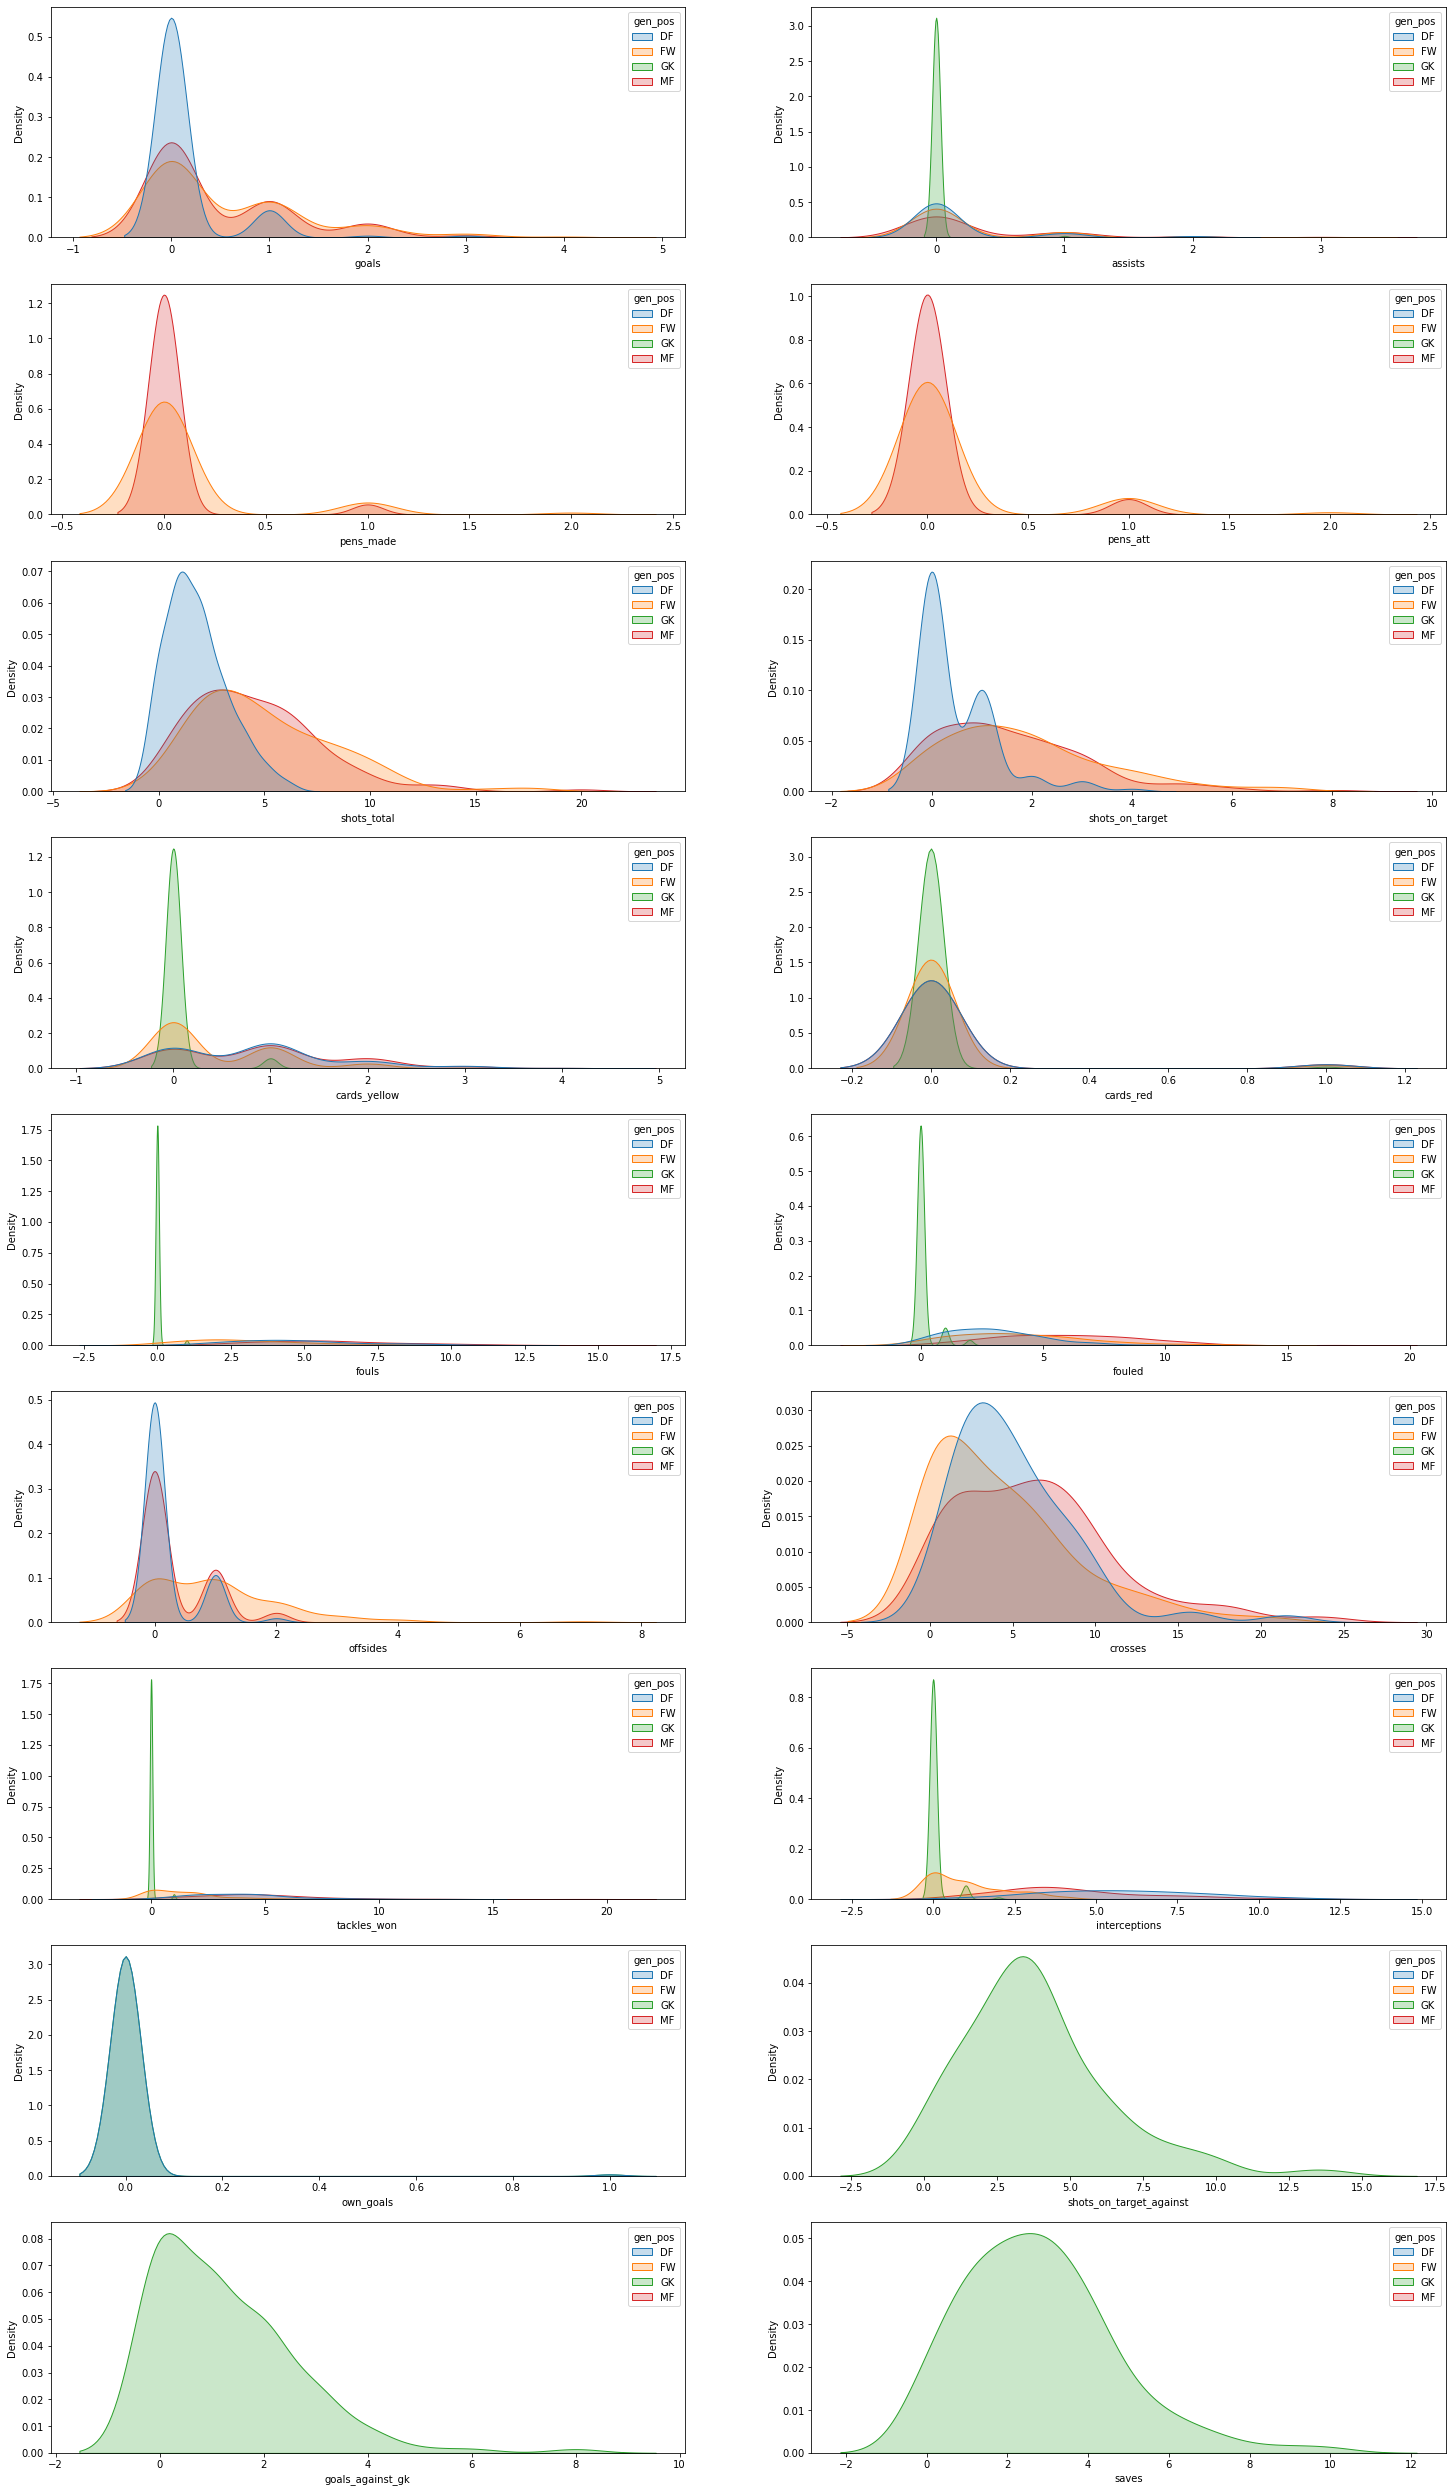

In [96]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

c_group = ['date', 'squad_home_away', 'squad', 'opponent', 'possession', 'round', 'points', 'qualified']
c_agg = ['goals','assists', 'pens_made', 'pens_att', 'shots_total', 'shots_on_target', 'cards_yellow', 'cards_red','fouls',
'fouled','offsides','crosses','tackles_won','interceptions','own_goals','shots_on_target_against','goals_against_gk','saves']
c_result = ['qualified']

fig, ax = plt.subplots(figsize = (25,45), nrows = 9, ncols = 2)

posx = 0
posy = 0

for c in c_agg:
    df = df_match_agg.loc[(df_match_agg[c].notnull())]
    sns.kdeplot(ax=ax[posy,posx] , data=df, x=c, hue='gen_pos', shade=True)#, common_norm=False, alpha=0.4)
    posx += 1
    
    if posx == 2:
        posy += 1
        posx = 0

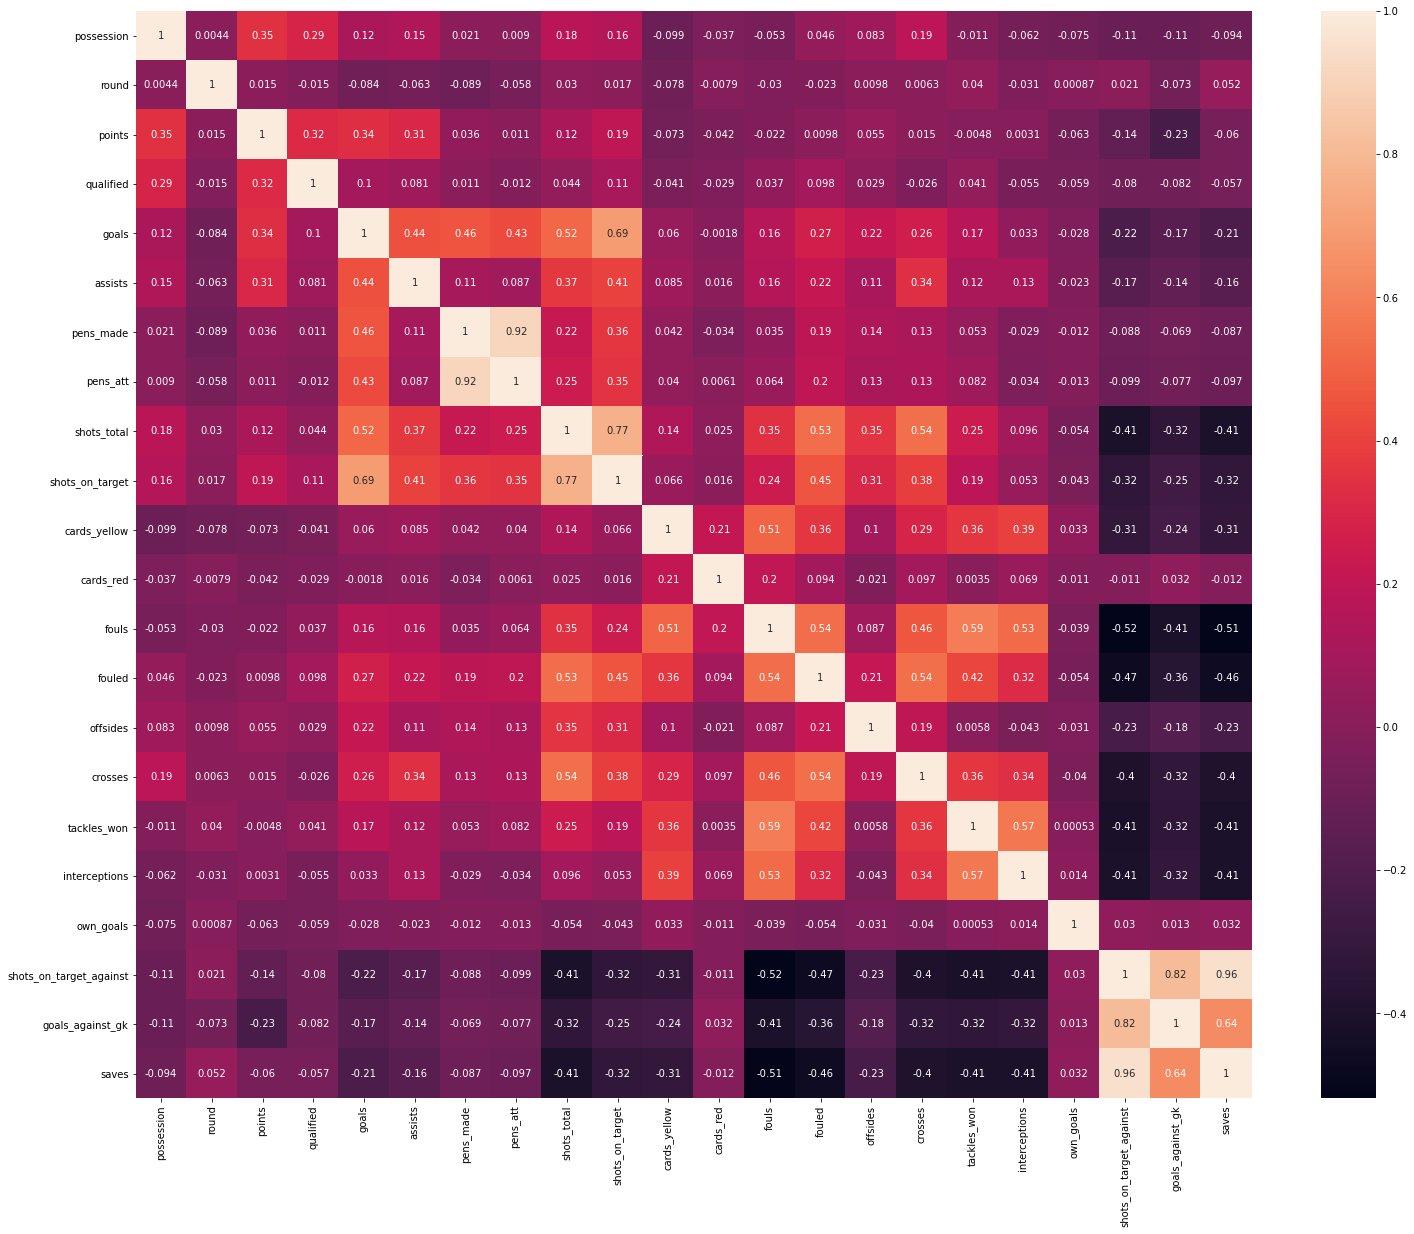

In [114]:
plt.figure(figsize = (25,20))
ax = sns.heatmap(df_match_agg.corr(), annot = True)

In [115]:
c_gk = ['date', 'squad', 'opponent', 'venue', 'formation', 'round', 'qualified', 'points', 'gen_pos', 
        'shots_on_target_against','goals_against_gk','saves']

c_nogk = ['date', 'squad', 'opponent', 'venue', 'formation', 'round', 'qualified', 'points', 'gen_pos', 
          'goals','assists', 'pens_made', 'pens_att', 'shots_total', 'shots_on_target', 'cards_yellow', 
          'cards_red','fouls', 'fouled','offsides','crosses','tackles_won','interceptions']

df_squad_gk = df_match_agg[df_match_agg["gen_pos"]=="GK"][c_gk]
df_squad_nogk = df_match_agg[df_match_agg["gen_pos"]!="GK"][c_nogk]

df_squad_gk = pd.get_dummies(df_squad_gk, columns=['venue','formation'])
df_squad_nogk = pd.get_dummies(df_squad_nogk, columns=['venue','formation','gen_pos'])

# Modeling:
## Selecting features

In [207]:
from sklearn.preprocessing import StandardScaler

c_model = ['goals','assists','pens_made','pens_att','shots_total','shots_on_target',
           'cards_yellow','cards_red','fouls','fouled','offsides','crosses','tackles_won','interceptions',
           'venue_Away','venue_Home','formation_3-1-4-2', 'formation_3-4-1-2', 'formation_3-4-3',
           'formation_3-5-2','formation_4-1-4-1','formation_4-2-2-2','formation_4-2-3-1','formation_4-3-1-2', 
           'formation_4-3-2-1','formation_4-3-3','formation_4-4-1-1','formation_4-4-2','formation_4-5-1', 
           'formation_5-3-2','formation_5-4-1','gen_pos_DF','gen_pos_FW','gen_pos_MF','qualified']

df_nogk_train = df_squad_nogk[df_squad_nogk["round"] == 1][c_model]
df_nogk_test = df_squad_nogk[df_squad_nogk["round"] == 2][c_model]

df_x = df_squad_nogk[c_model].iloc[:,:-1]
df_y = df_squad_nogk['qualified']

scaler = StandardScaler()
scaler.fit(df_nogk_train)

df_nogk_train_s = scaler.transform(df_nogk_train)
df_nogk_test_s = scaler.transform(df_nogk_test)

df_x_train = df_nogk_train_s[:,:-1]
df_y_train = df_nogk_train.iloc[:,-1]

df_x_test = df_nogk_test_s[:,:-1]
df_y_test = df_nogk_test.iloc[:,-1]


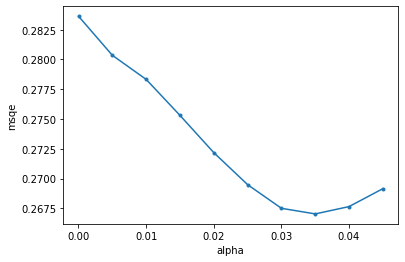

Best alpha: 0.035010000000000006 , MSE: 0.26702569976739515


In [208]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

alphas_lasso = [ i for i in np.arange(0.00001, 0.05, 0.005) ]
mse_lasso = []

np.random.seed(123) 

for a in alphas_lasso:
    score_lasso = -1*cross_val_score(Lasso(alpha = a), df_x_train, df_y_train, cv = 10, scoring = 'neg_mean_squared_error')
    mse_lasso.append(np.mean(score_lasso))

plt.plot(alphas_lasso, mse_lasso, marker='.')
plt.xlabel("alpha")
plt.ylabel("msqe")
plt.show()

min_mse_lasso = np.min(mse_lasso)
best_alpha_lasso = alphas_lasso[mse_lasso.index(min_mse_lasso)]

print('Best alpha:', best_alpha_lasso, ', MSE:', min_mse_lasso )


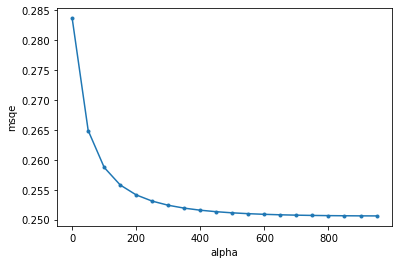

Best alpha: 950.00001 , MSE: 0.25064524214646355


In [175]:
from sklearn.linear_model import Ridge

warnings.filterwarnings('ignore')

alphas_ridge = [ i for i in np.arange(0.00001,1000,50) ]
mse_ridge = []

np.random.seed(123) 

for a in alphas_ridge:
    score_ridge = -1*cross_val_score(Ridge(alpha = a), df_x_train, df_y_train, cv = 10, scoring = 'neg_mean_squared_error')
    mse_ridge.append(np.mean(score_ridge))

plt.plot(alphas_ridge, mse_ridge, marker='.')
plt.xlabel("alpha")
plt.ylabel("msqe")
plt.show()

min_mse_ridge = np.min(mse_ridge)
best_alpha_ridge = alphas_ridge[mse_ridge.index(min_mse_ridge)]

print('Best alpha:', best_alpha_ridge, ', MSE:', min_mse_ridge )

In [202]:
from sklearn.metrics import confusion_matrix

def show_metrics(p_test, p_predict):
    tn, fp, fn, tp = confusion_matrix(p_test, p_predict).ravel()

    accuracy = (( (tp + tn) / (tp + fp + tn + fn) ) * 100).round(2)
    precision = (( tp / (tp + fp) ) * 100).round(2)
    recall = (( tp / (tp + fn) ) * 100).round(2)
    f1 = (( 2*tp / (2*tp + fp + fn) ) * 100).round(2)

    return "accuracy: " + str(accuracy) + "% precision: " + str(precision) + "% recall: " + str(recall) + "% f1: " + str(f1) + "%"


In [203]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.035)
lasso.fit(df_x_train,df_y_train)

def print_coefficients(coefs, names = None, sort = False): 
    return [c_model[i] + ": " + str(round(c, 3)) for i, c in zip(range(len(coefs)),coefs) if c > 0 or c < 0]
        
print ("Lasso model:", print_coefficients(lasso.coef_))

y_pred_lr = lasso.predict(df_x_test)

show_metrics(df_y_test, y_pred_lr.round())


Lasso model: ['goals: 0.034', 'assists: 0.017', 'pens_att: -0.001', 'fouls: 0.015', 'fouled: 0.005', 'formation_3-5-2: -0.022', 'formation_4-2-2-2: 0.047', 'formation_4-3-2-1: 0.025', 'formation_4-4-1-1: 0.046', 'formation_4-4-2: -0.024', 'formation_4-5-1: -0.047', 'formation_5-3-2: -0.048', 'formation_5-4-1: -0.022']


'accuracy: 52.94% precision: 52.31% recall: 34.34% f1: 41.46%'

In [204]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.utils import shuffle
from IPython.display import display

def model_cart(p_x, p_y):
    model_cart = DecisionTreeClassifier(random_state = 123)
    return model_cart.fit(p_x, p_y)

def model_randomforest(p_x, p_y, p_n_estimators=None):
    if p_n_estimators is None:
        model_cart = RandomForestClassifier(random_state = 123)
    else:
        model_cart = RandomForestClassifier(random_state = 123, n_estimators=p_n_estimators)
    return model_cart.fit(p_x, p_y)

def show_cart_tree(p_model, p_depth):
    fig = plt.figure(figsize=(25,10))
    tree.plot_tree(p_model, fontsize=7, max_depth=p_depth, filled=True, rounded=True )
    plt.show()

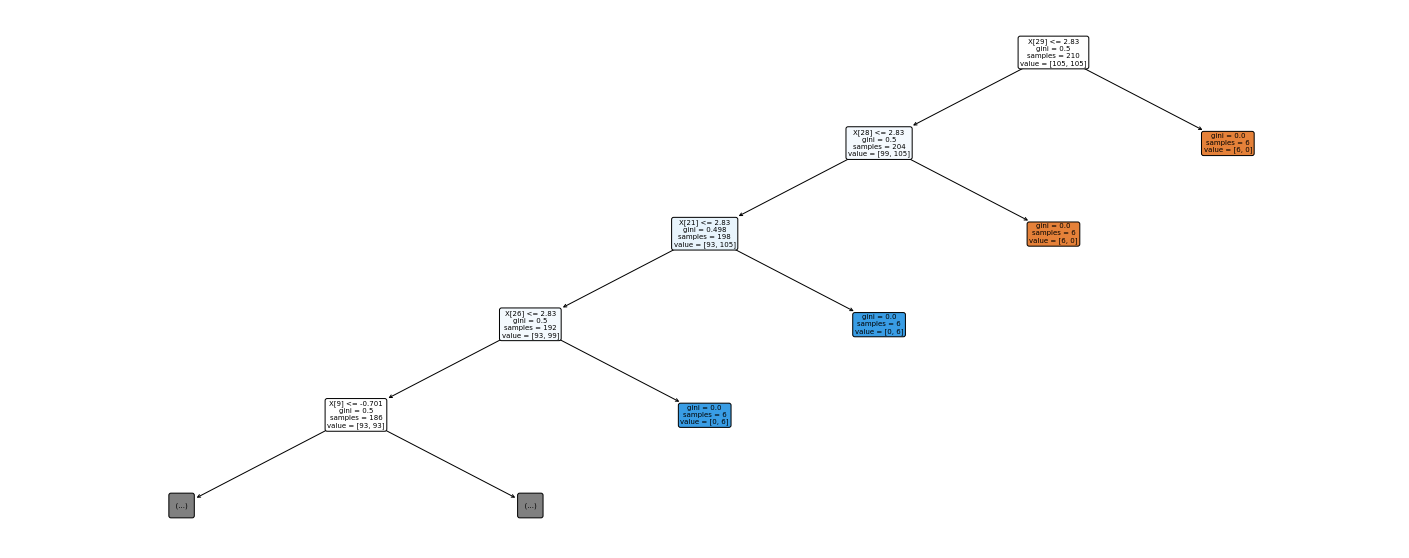

'accuracy: 58.33% precision: 57.29% recall: 55.56% f1: 56.41%'

In [205]:
m_cart = model_cart(df_x_train, df_y_train)
show_cart_tree(m_cart, p_depth=4)

y_pred_cart = m_cart.predict(df_x_test)
show_metrics(df_y_test, y_pred_cart.round())
